In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
mu = 0.02             # Drift (expected return)
sigma = 0.1           # Volatility (random fluctuations)
gamma = 0.05          # Decoherence rate
num_steps = 50      # Time steps in the evolution

In [2]:
def Bernoulli_gate(p):
    return RYGate(2*np.arcsin(np.sqrt(p))) 


def styled_line_plot(x, y, title, out_path):
    BACKGROUND_COLOR = "#191919"

    fig, ax = plt.subplots(figsize=(8, 4))
    fig.patch.set_facecolor(BACKGROUND_COLOR)

    ax.set_facecolor(BACKGROUND_COLOR)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')

    ax.plot(x, y, marker='o', linestyle='-', color='royalblue', label="Quantum Brownian Motion")
    plt.xlabel("Time Steps", {"color": "white"})
    plt.ylabel("Time Steps", {"color": "white"})
    plt.title(title, {"color": "white"})
    
    plt.savefig(out_path)
    plt.show()

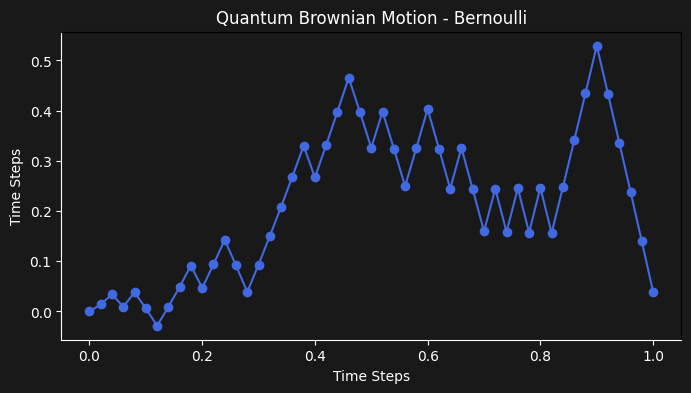

In [3]:
from qiskit_aer import AerSimulator


P = 0.5 # Bernoulli p
B_0 = 0
values = [B_0]

simulator = AerSimulator()
time_steps = np.linspace(0, 1, num_steps + 1)
for t in time_steps[1:]:
    # Circuit definition
    qc = QuantumCircuit(1)
    qc.append(Bernoulli_gate(P), [0])
    qc.measure_all()
    
    # Run simulation
    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts(qc)
    total = sum(counts.values())

    # Check outcome
    down = counts.get('0')
    up = counts.get('1')

    # Map to asset price: Measure |0> → price decreases, Measure |1> → price increases
    delta_sign = bool(down)*-1 + bool(up)*1
    S_t = values[-1] + np.sqrt(t) * sigma * delta_sign
    values.append(S_t)


styled_line_plot(time_steps, values, "Quantum Brownian Motion - Bernoulli", "images/bernoulli.png")

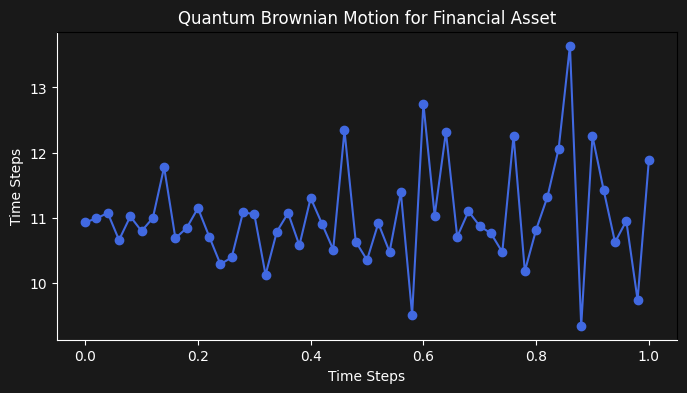

In [4]:
from qiskit_aer import AerSimulator


num_shots = 1024      # Number of measurements
P = 0.5
SD = np.sqrt(P * (1 - P)/num_shots)

S_0 = 10.93
prices = [S_0]

simulator = AerSimulator()
time_steps = np.linspace(0, 1, num_steps + 1)
for t in time_steps[1:]:
    qc = QuantumCircuit(1)
    qc.append(Bernoulli_gate(P), [0])
    qc.measure_all()

    # # Encode initial price state (superposition for flexibility)
    # qc.h(0)  # Put qubit in superposition
    # qbm_step(qc, 0, mu, sigma, gamma)
    
    # Run simulation
    result = simulator.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    total = sum(counts.values())

    # Compute quantum probabilities
    price_down = counts.get('0') / num_shots
    price_up = counts.get('1') / num_shots

    random_norm = (price_up - P)/SD
    
    S_t = S_0 * np.exp((mu - sigma**2/2) * t + np.sqrt(t) * sigma * random_norm)
    prices.append(S_t)


styled_line_plot(time_steps, prices, "Quantum Brownian Motion for Financial Asset", "images/normal.png")